### Evaluate final U-Net models on CESM and FOCI prec data

In [1]:
import os
import sys
sys.path.append('../reconstruct_missing_data')

from pathlib import Path
from json import dump, load

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

from data_loading import (
    find_data_files, 
    load_data_set, 
    get_anomalies, 
    clone_data, 
    create_missing_mask, 
    split_and_scale_data,
    area_mean_weighted,
    spatial_mask,
)
from models import build_unet_4conv
from indices import (
    southern_annular_mode_zonal_mean,
    north_atlantic_oscillation_station,
    north_pacific,
    el_nino_southern_oscillation_34,
    atlantic_multidecadal_oscillation,
)

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate, Conv1D, Conv2D, MaxPool2D, UpSampling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model

# Suppress Tensorflow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
# Set working directory, according to working directory in scripts:
os.chdir('/gxfs_work1/geomar/smomw511') # nesh
# os.chdir('/Users/mlandt-hayen') # local
# os.chdir('/work') # local in Docker Container

In [3]:
## Specify parameters:

# Source: 'CESM', 'FOCI'
source = 'CESM'
feature = 'precipitation'
feature_short = 'prec'
missing_values = [0.999,0.99,0.95]

# Further parameters for pre-processing inputs and targets:
train_val_split = 0.8
scale_to = 'zero_one'


## Set paths to final models and set shortnames for final models:

paths_to_final_models=[
    'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/predict_unet_4conv_multivariate_prec_'+source+'_optimal_discrete_lead_0_final',
    'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/predict_unet_4conv_multivariate_prec_'+source+'_optimal_discrete_lead_1_final',
    'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/predict_unet_4conv_multivariate_prec_'+source+'_optimal_discrete_lead_3_final',
]


model_shortnames=[
    'lead 0',
    'lead 1',
    'lead 3',
]

In [4]:
# Load test loss per sample for first model, to infer number of test samples, 
# lat and lon, and number of missing value rates. 
# Note: Infer number of test samples from last experiment with max. lead time.
n_test=np.load(Path(paths_to_final_models[-1]) / 'test_loss_per_sample_all.npy').shape[-1]
lat=np.load(Path(paths_to_final_models[0]) / 'test_loss_map_all.npy').shape[1]
lon=np.load(Path(paths_to_final_models[0]) / 'test_loss_map_all.npy').shape[2]
n_missing=np.load(Path(paths_to_final_models[0]) / 'test_loss_per_sample_all.npy').shape[0]

# # Initialize storage for parameters:
# feature_all = []
# feature_short_all = []
# source_all = []
# mask_type_all = []
# missing_type_all = []
# augmentation_factor_all = []
# missing_values_all = []

# Initialize storage for reloaded results, for all models and missing rates.
test_loss_per_sample_all = np.zeros((len(paths_to_final_models),n_missing,n_test))
test_loss_map_all = np.zeros((len(paths_to_final_models),n_missing,lat,lon))
SPI_test_pred_all = np.zeros((len(paths_to_final_models),n_missing,n_test))
SPI_test_target_all = np.zeros((len(paths_to_final_models),n_missing,n_test))

# Loop over final models:
for i in range(len(paths_to_final_models)):
    
    # Get path to final model:
    path_to_final_model = paths_to_final_models[i]
    
    # Reload parameters for this experiment:
    with open(Path(path_to_final_model) / 'parameters.json', 'r') as f:
        parameters=load(f)

#     # Store parameters:    
#     feature_all.append(parameters['feature'])
#     feature_short_all.append(parameters['feature_short'])
#     source_all.append(parameters['source'])
#     mask_type_all.append(parameters['mask_type'])
#     missing_type_all.append(parameters['missing_type'])
#     augmentation_factor_all.append(parameters['augmentation_factor'])
#     missing_values_all.append(parameters['missing_values'])
    
    ## Reload results.   
    ## Different experiments have different lead time and hence, different number of test samples.
    ## Take number of test samples from last experiment with max. lead time and hence, minimum number of test samples.
    test_loss_per_sample_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'test_loss_per_sample_all.npy')[:,:n_test]
    test_loss_map_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'test_loss_map_all.npy')
    SPI_test_pred_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'SPI_test_pred_all.npy')[:,:n_test]
    SPI_test_target_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'SPI_test_target_all.npy')[:,:n_test]


### Index (SPI) on reconstructed vs. complete fields

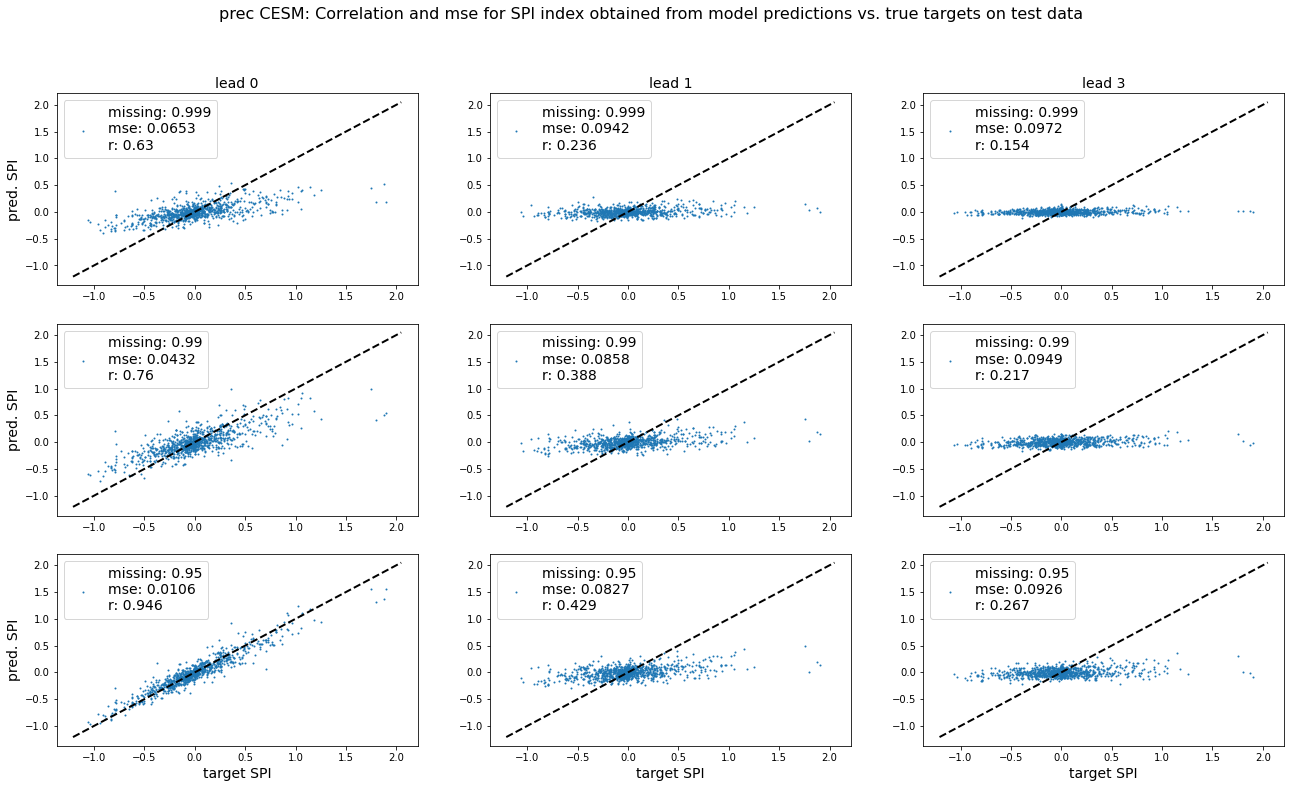

In [5]:
## prec CESM

## Show scatterplot of indices obtained from model predictions vs. true targets (=complete samples).

# Set number of missing rates to include:
n_missing_rates = 3

# Set number of samples to include:
n_samples = n_test

# Initialize plot for ENSO:
fig, axes = plt.subplots(n_missing_rates,len(model_shortnames),figsize=(22,12))

# Loop over rates of missing values:
for r in range(n_missing_rates):

    # Loop over models:
    for model_number in range(len(model_shortnames)):

        axes[r,model_number].scatter(SPI_test_target_all[model_number,r,:n_samples], SPI_test_pred_all[model_number,r,:n_samples], s=1,
                                   label=
                                     'missing: '+str(missing_values[r])+'\nmse: '+
                                     str(np.round(np.mean(np.mean((SPI_test_target_all[model_number,r,:n_samples]-SPI_test_pred_all[model_number,r,:n_samples])**2)),4))+'\nr: '+
                                     str(np.round(np.corrcoef(np.stack([SPI_test_target_all[model_number,r,:n_samples],SPI_test_pred_all[model_number,r,:n_samples]]))[0,1],3))
                                    )
        if r == 0:
            axes[r,model_number].set_title(model_shortnames[model_number], fontsize=14)
        if r == n_missing_rates-1:
            axes[r,model_number].set_xlabel('target SPI', fontsize=14)
        if model_number == 0:
            axes[r,model_number].set_ylabel('pred. SPI', fontsize=14)
        axes[r,model_number].legend(fontsize=14)
        
        x = np.linspace(*axes[r,model_number].get_xlim())
        axes[r,model_number].plot(x, x, linestyle='--', color='k', lw=2)

fig.suptitle('prec CESM: Correlation and mse for SPI index obtained from model predictions vs. true targets on test data', fontsize=16)
plt.show()

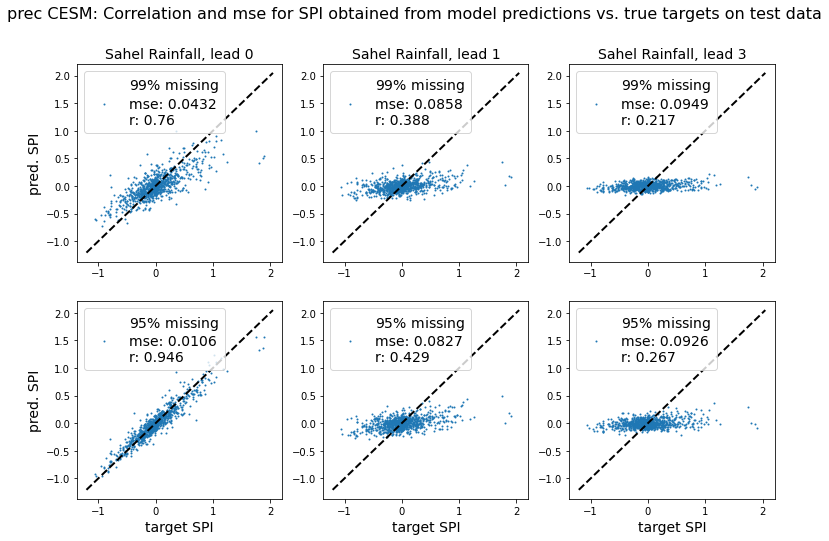

In [12]:
## prec CESM

# Set missing rates for figure titles:
missing_rates = [99.9, 99, 95]

## Show scatterplot of indices obtained from model predictions vs. true targets (=complete samples).

# Set number of missing rates to include:
n_missing_rates = 2

# Set number of samples to include:
n_samples = n_test

# Initialize plot for ENSO:
fig, axes = plt.subplots(n_missing_rates,len(model_shortnames),figsize=(12.5,8))

# Loop over rates of missing values:
for r in np.arange(1,1+n_missing_rates):

    # Loop over models:
    for model_number in range(len(model_shortnames)):

        axes[r-1,model_number].scatter(SPI_test_target_all[model_number,r,:n_samples], SPI_test_pred_all[model_number,r,:n_samples], s=1,
                                   label=
                                     str(missing_rates[r])+'$\%$ missing'+'\nmse: '+
                                     str(np.round(np.mean(np.mean((SPI_test_target_all[model_number,r,:n_samples]-SPI_test_pred_all[model_number,r,:n_samples])**2)),4))+'\nr: '+
                                     str(np.round(np.corrcoef(np.stack([SPI_test_target_all[model_number,r,:n_samples],SPI_test_pred_all[model_number,r,:n_samples]]))[0,1],3))
                                    )
        if r == 1:
            axes[r-1,model_number].set_title('Sahel Rainfall, '+model_shortnames[model_number], fontsize=14)
        if r == n_missing_rates:
            axes[r-1,model_number].set_xlabel('target SPI', fontsize=14)
        if model_number == 0:
            axes[r-1,model_number].set_ylabel('pred. SPI', fontsize=14)
        axes[r-1,model_number].legend(fontsize=14)
        
        x = np.linspace(*axes[r-1,model_number].get_xlim())
        axes[r-1,model_number].plot(x, x, linestyle='--', color='k', lw=2)

fig.suptitle('prec CESM: Correlation and mse for SPI obtained from model predictions vs. true targets on test data', fontsize=16)
plt.show()

### Find samples that clearly show outperformance of optimal models for reconstructing from ultra sparse inputs

In [5]:
## Load data, get anomalies:

if source=='realworld':
    
    # Specify path to data:
    path_to_data = "GitHub/MarcoLandtHayen/reconstruct_missing_data/data/raw/sst.mnmean.nc"
    
    # Open data set:
    sst_dataset=xr.open_dataset("GitHub/MarcoLandtHayen/reconstruct_missing_data/data/raw/sst.mnmean.nc")

    # Start with raw slp fields as lat/lon grids in time, from 1880 to 2022:
    sst_fields = (
        sst_dataset.sst
        .sel(time=slice('1880-01-01', '2022-12-01'))
    )

    # Compute monthly climatology (here 1980 - 2009) for whole world:
    sst_climatology_fields = (
        sst_dataset.sst
        .sel(time=slice('1980-01-01','2009-12-01'))
        .groupby("time.month")
        .mean("time")
    )

    # Get slp anomaly fields by subtracting monthly climatology from raw slp fields:
    sst_anomaly_fields = sst_fields.groupby("time.month") - sst_climatology_fields

    # Adjust latitude and longitude, to have even number of steps in latitude (=80)
    # and longitude (=176), that can be evenly divided 4 times by two. This serves as 'quick-and-dirty'
    # solution to avoid problems with UPSAMPLING in U-Net. There must be a more elegant way, take care of it later!
    feature_anomaly = sst_anomaly_fields.values[:,5:-4,:-4]

else:

    # Specify path to data: 
    data_path='climate_index_collection/data/raw/2022-08-22/'

    # Load data:
    data = load_data_set(data_path=data_path, data_source_name=source)

    # Extract feature:
    feature_raw = data[feature]
    
    # Remove seasonal cycle to get anomalies, use whole time span as climatology:
    climatology = feature_raw.groupby("time.month").mean("time")
    feature_anomaly = (feature_raw.groupby("time.month") - climatology).drop("month")

In [6]:
# Create synthetic missing_mask of ONEs, to load FULL validation samples:
missing_mask_1 = (np.ones(feature_anomaly.shape)==1)

# Get scaled validation inputs and targets. Note: Using missing_mask of ONEs, validation inputs and targets are 
# identical. Only difference is found in dimensionality: inputs have channel number (=1) as final dimension, targets don't.
_, val_input, _, val_target, train_min, train_max, _, _ = split_and_scale_data(
    feature_anomaly, 
    missing_mask_1,
    train_val_split=train_val_split, 
    scale_to=scale_to
)

In [7]:
# Set zero values in targets to NaN, to highlight land masses and correct contrast in SST anomalies:
val_target_nan = np.copy(val_target)
val_target_nan[val_target_nan==0] = float('nan')

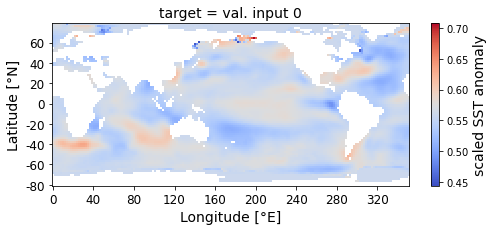

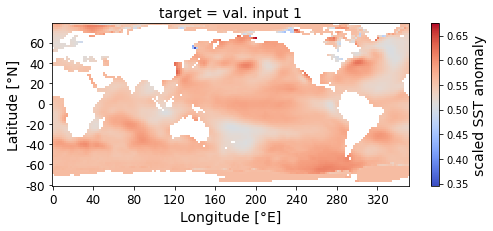

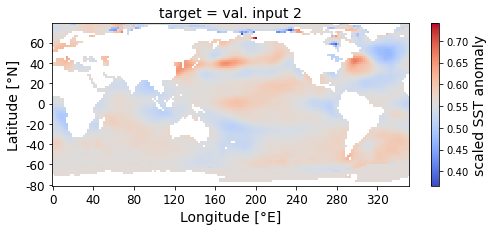

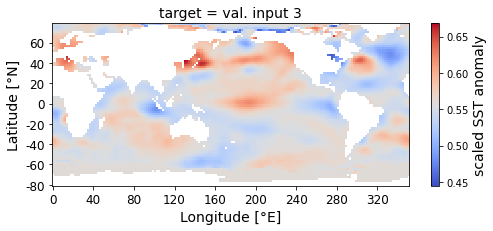

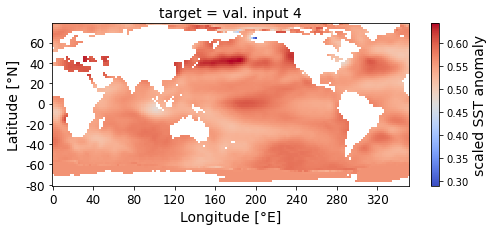

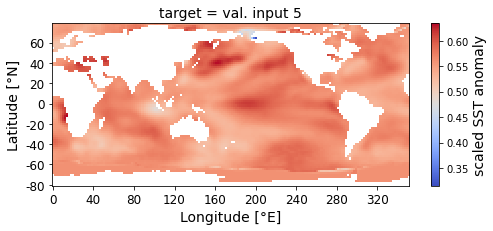

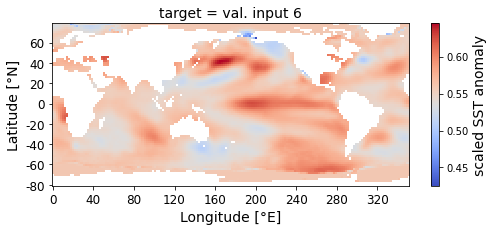

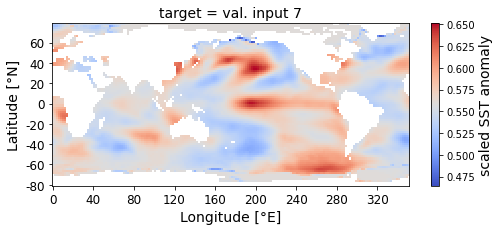

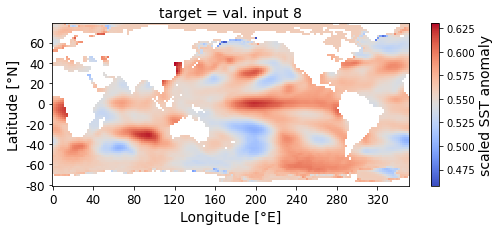

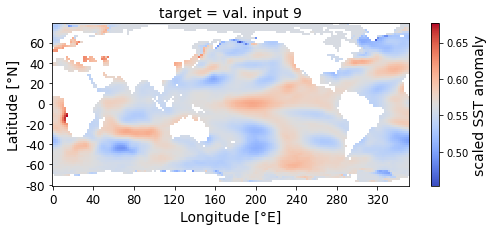

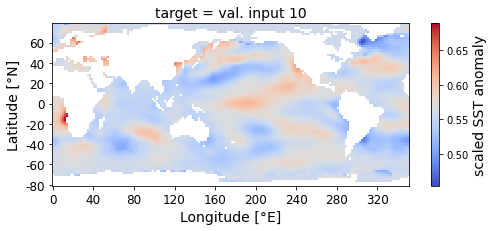

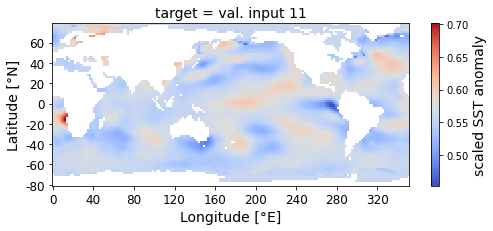

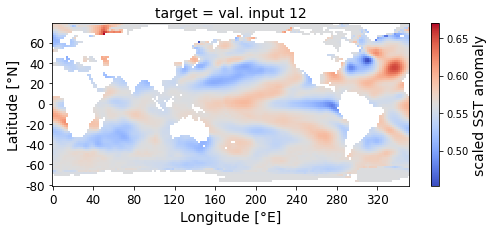

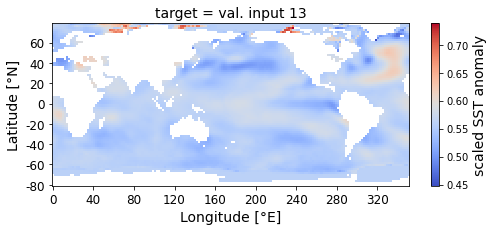

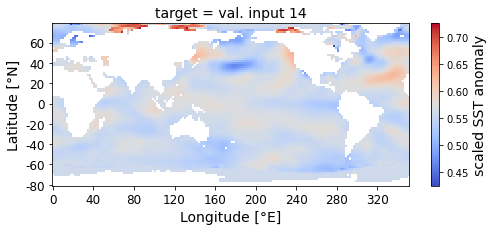

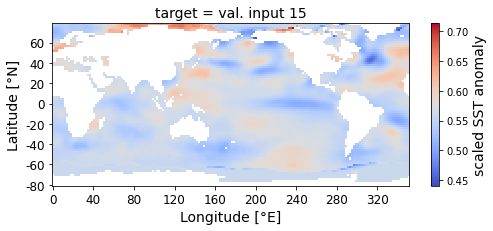

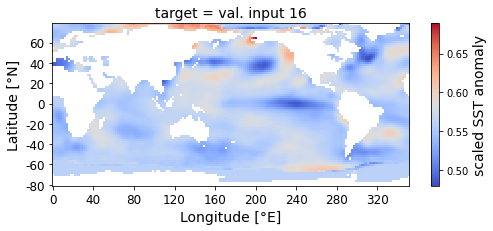

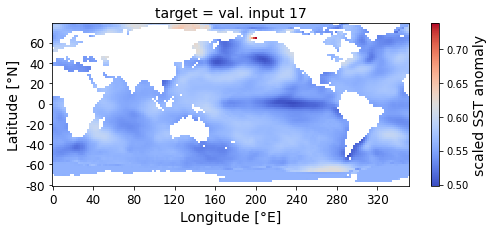

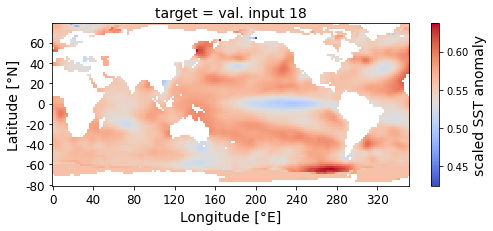

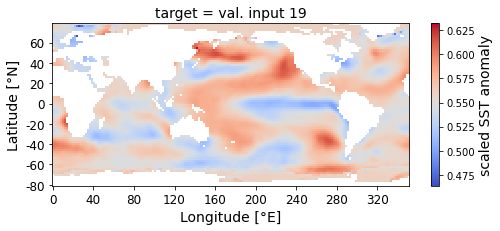

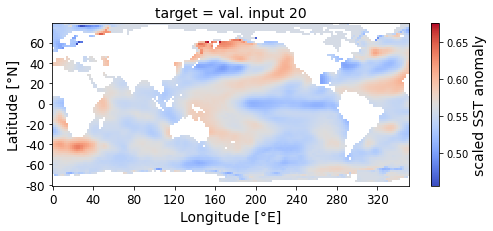

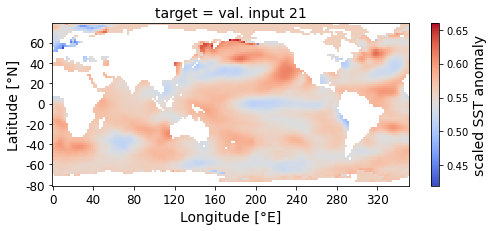

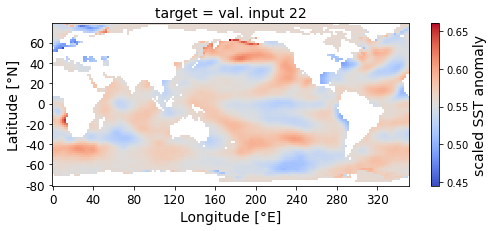

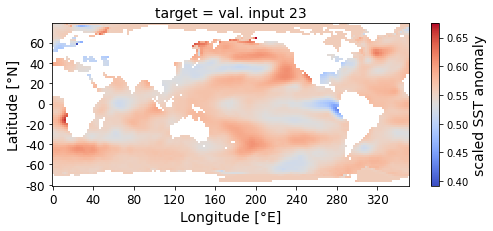

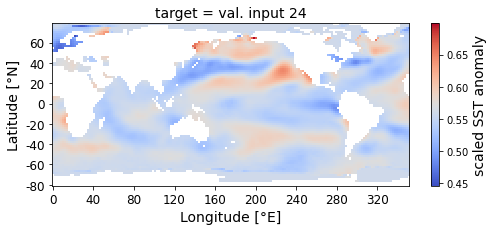

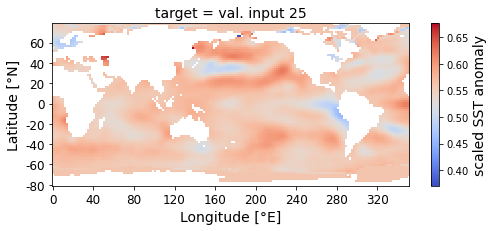

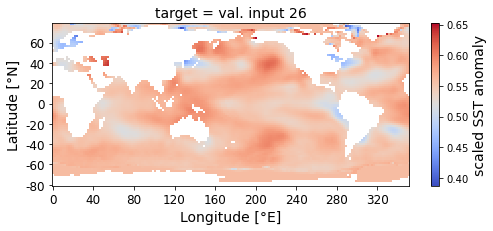

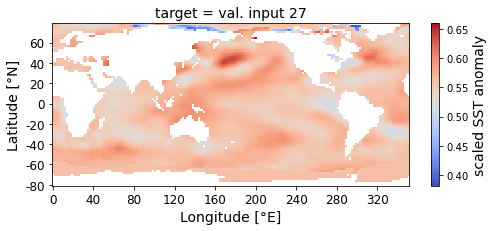

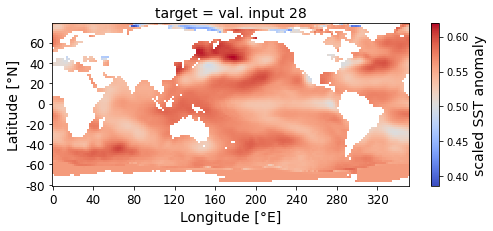

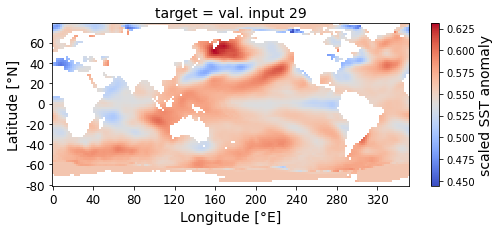

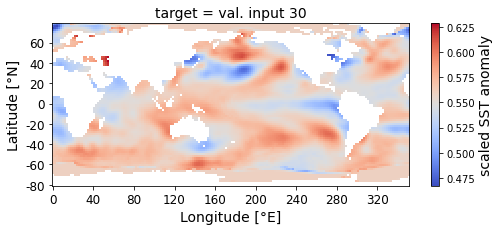

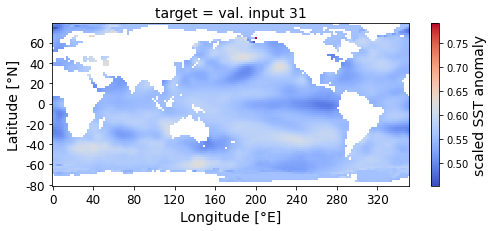

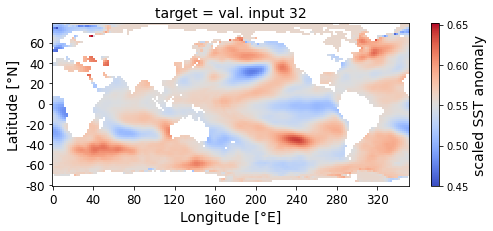

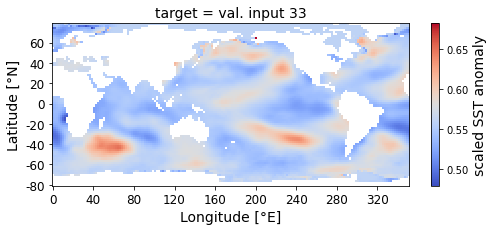

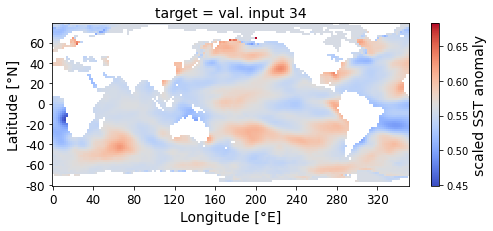

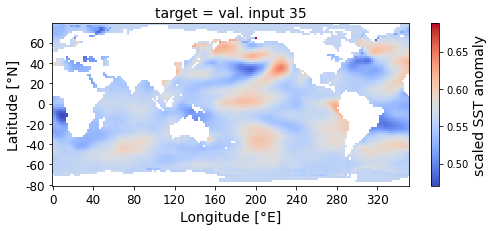

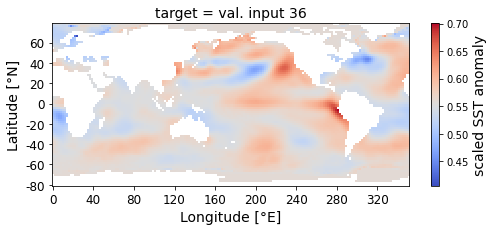

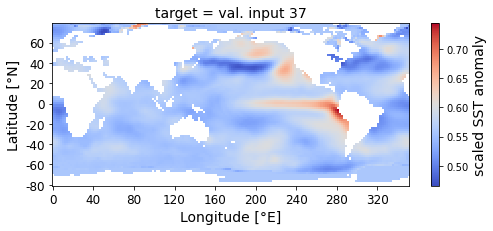

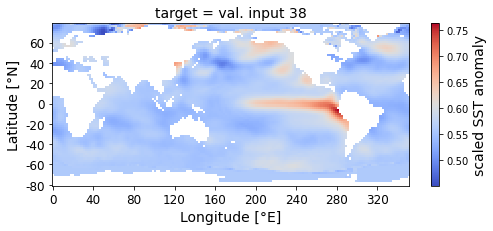

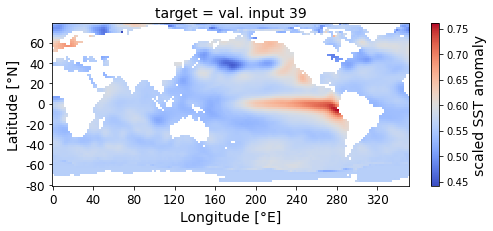

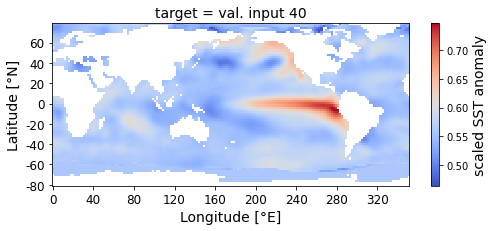

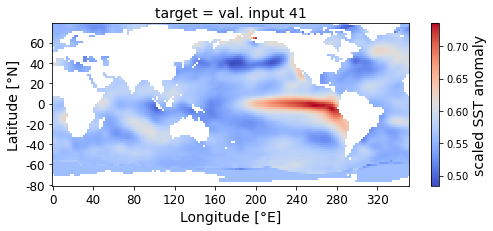

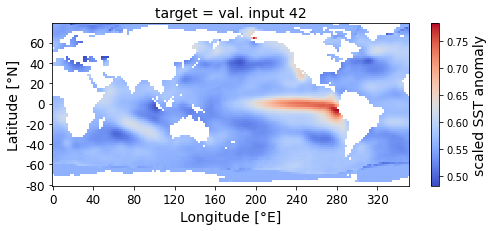

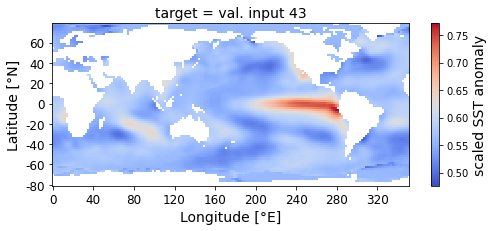

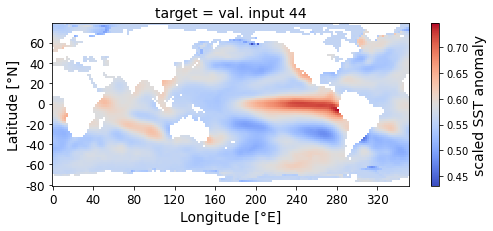

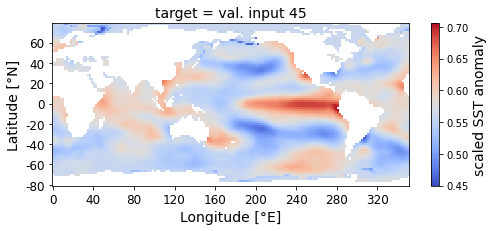

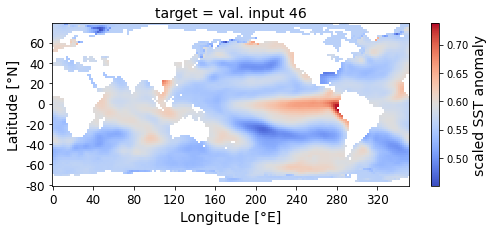

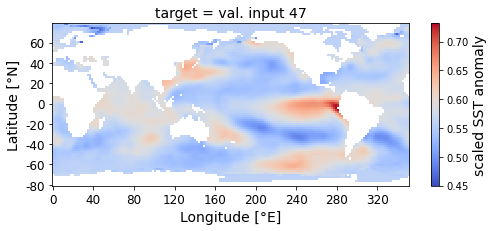

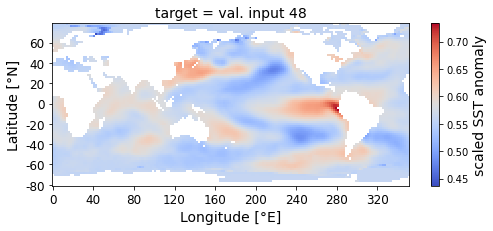

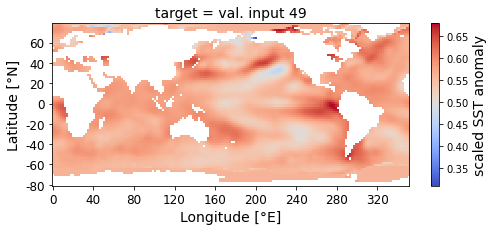

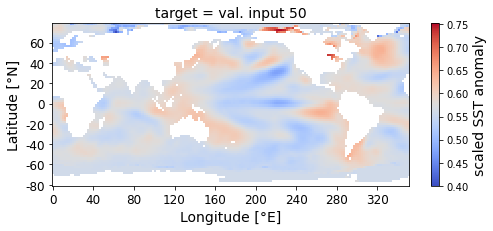

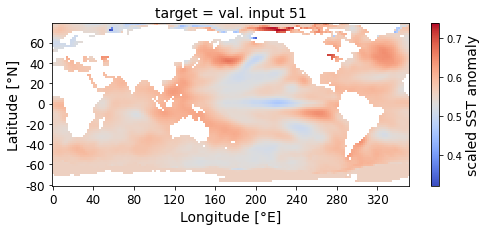

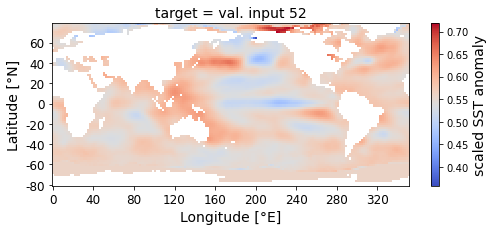

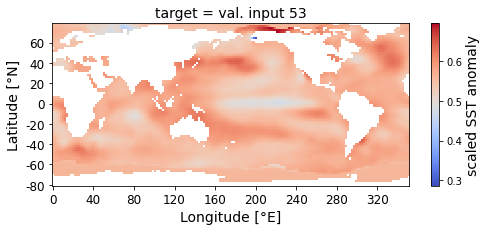

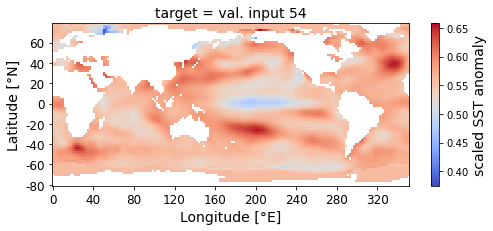

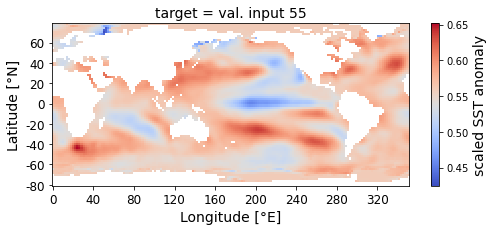

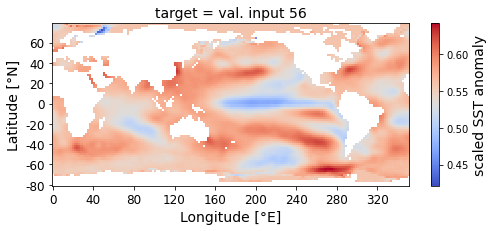

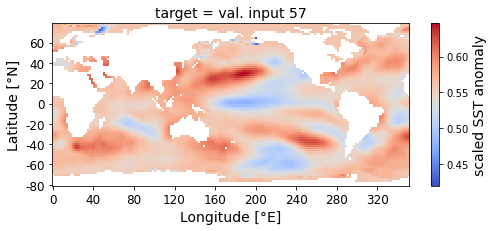

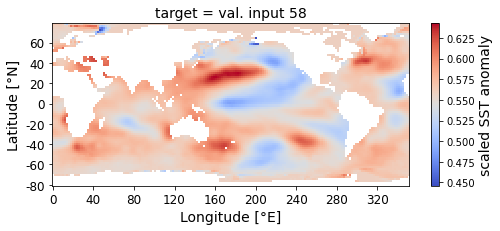

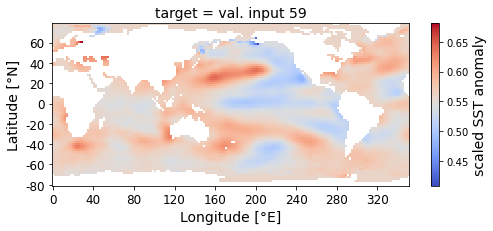

In [36]:
## Plot some validation targets (=complete samples):

# Specify number of samples to consider:
n_samples = 60

# Loop over samples:
for n in range(n_samples):
    
    ## Plot target:
    fig, ax = plt.subplots(figsize=(8, 3))
    im = plt.imshow(val_target_nan[n], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label("scaled SST anomaly", fontsize=14)
    plt.title('target = val. input '+str(n), fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    # Set x- and y-ticks according to source:
    if source=='realworld':
        plt.xticks(np.arange(0, 176, step=20), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
        plt.yticks(np.arange(9, 80, step=10), [60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    elif source=='CESM':
        plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
        plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    else:
        plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
        plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    plt.show()

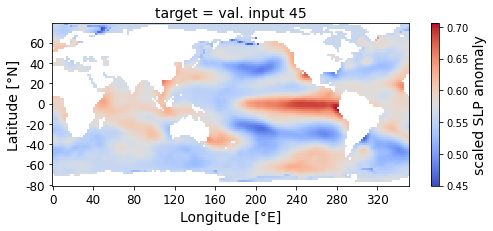

In [8]:
## Plot single target:

# Pick sample number:
sample = 45

# Plot:
fig, ax = plt.subplots(figsize=(8, 3))
im = plt.imshow(val_target_nan[sample], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("scaled SLP anomaly", fontsize=14)
plt.title('target = val. input '+str(sample), fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
# Set x- and y-ticks according to source:
if source=='realworld':
    plt.xticks(np.arange(0, 176, step=20), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
    plt.yticks(np.arange(9, 80, step=10), [60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
elif source=='CESM':
    plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
    plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
else:
    plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
    plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

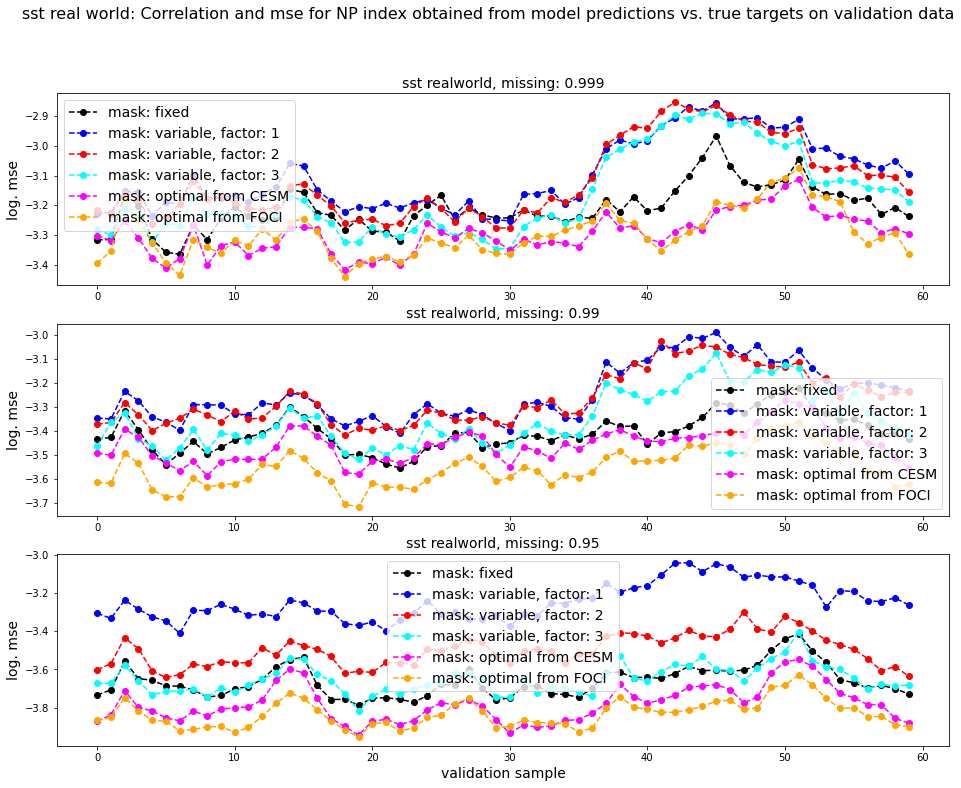

In [35]:
## Plot val. loss for several validation samples for all models and specified rates of missing values:

# Set number of missing rates to include:
n_missing_rates = 3

# Set colors and linestyles for individual models:
colors = ['black', 'blue', 'red', 'cyan', 'magenta', 'orange']
linestyles = ['--', '--', '--', '--', '--', '--']

# Initialize plot:
fig, axes = plt.subplots(n_missing_rates,1,figsize=(16,12))

# Loop over rates of missing values:
for r in range(n_missing_rates):

    # Loop over models:
    for model_number in range(len(model_shortnames)):

        axes[r].plot(
            np.log10(val_loss_per_sample_all[model_number,r,:n_samples]),
            color=colors[model_number],
            label=model_shortnames[model_number],
            marker = 'o', linestyle = linestyles[model_number],
        )
                
        axes[r].set_title(feature_short+' '+source+', missing: '+str(missing_values_all[model_number][r]), fontsize=14)
        if r == n_missing_rates-1:
            axes[r].set_xlabel('validation sample', fontsize=14)
        axes[r].set_ylabel('log. mse', fontsize=14)
        axes[r].legend(fontsize=14)

fig.suptitle('sst real world: Correlation and mse for NP index obtained from model predictions vs. true targets on validation data', fontsize=16)
plt.show()

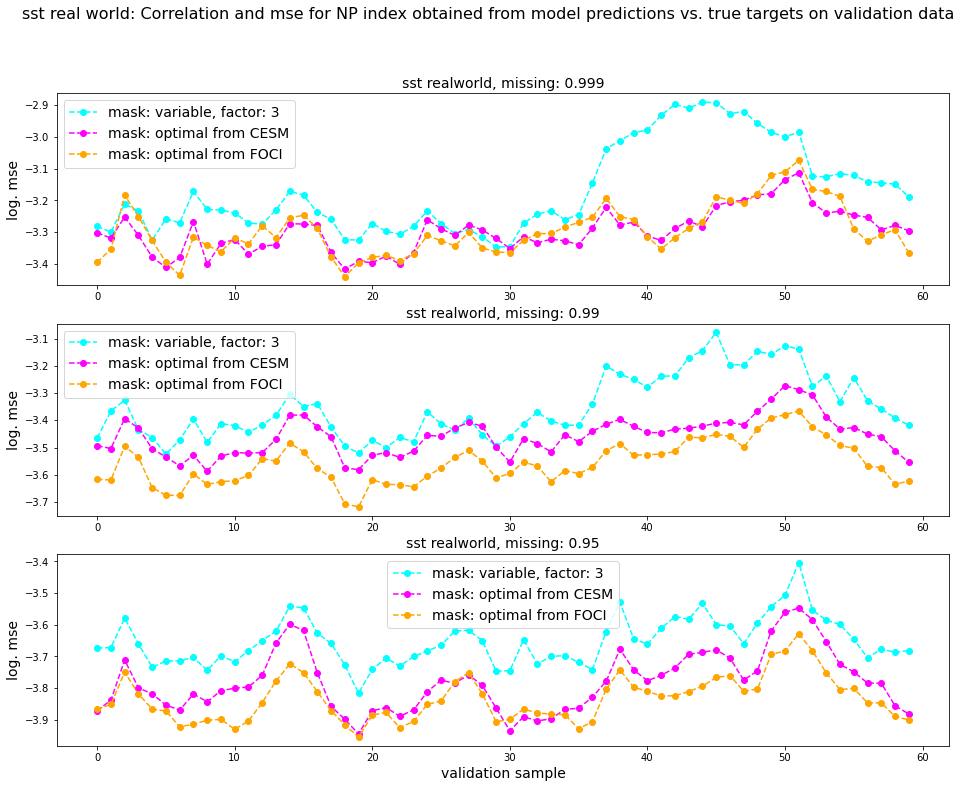

In [45]:
## Plot val. loss for selected validation samples for optimal models and model trained on variable mask with factor 3
## and specified rates of missing values:

# Specify start sample and number of samples:
start_sample = 0
n_samples = 60


# Set number of missing rates to include:
n_missing_rates = 3

# Set colors and linestyles for individual models:
colors = ['black', 'blue', 'red', 'cyan', 'magenta', 'orange']
linestyles = ['--', '--', '--', '--', '--', '--']

# Initialize plot:
fig, axes = plt.subplots(n_missing_rates,1,figsize=(16,12))

# Loop over rates of missing values:
for r in range(n_missing_rates):

    # Loop over models:
    for model_number in np.arange(3,len(model_shortnames)):

        axes[r].plot(
            np.arange(start_sample,start_sample+n_samples),
            np.log10(val_loss_per_sample_all[model_number,r,start_sample:start_sample+n_samples]),
            color=colors[model_number],
            label=model_shortnames[model_number],
            marker = 'o', linestyle = linestyles[model_number],
        )
                
        axes[r].set_title(feature_short+' '+source+', missing: '+str(missing_values_all[model_number][r]), fontsize=14)
        if r == n_missing_rates-1:
            axes[r].set_xlabel('validation sample', fontsize=14)
        axes[r].set_ylabel('log. mse', fontsize=14)
        axes[r].legend(fontsize=14)

fig.suptitle('sst real world: Correlation and mse for NP index obtained from model predictions vs. true targets on validation data', fontsize=16)
plt.show()

In [9]:
## Pick validation sample:
sample_number = 45

## Pick rate of missing values:
r = 0

# Get current rate of missing values:
missing = missing_values_all[0][r]
print('missing: ',missing)

missing:  0.999


In [75]:
# Initialize storage for model predictions. Dimension: (1,#models, lat, lon)
sample_pred_all = np.zeros((1,len(paths_to_final_models),val_input.shape[1],val_input.shape[2]))

# Loop over number of final models:
for m in range(len(paths_to_final_models)):
    
    # Get status:
    print('  model ',m+1,' of ',len(paths_to_final_models))
    
    # Get current augmentation factor:
    augmentation_factor = augmentation_factor_all[m]
    
    # Real world data needs separate pre-processing:
    if source == 'realworld':

        # Path to full data:
        path_to_data = "GitHub/MarcoLandtHayen/reconstruct_missing_data/data/raw/sst.mnmean.nc"  

        ## Load data:

        # Open data set:
        sst_dataset=xr.open_dataset(path_to_data)

        # Start with raw slp fields as lat/lon grids in time, from 1948 to 2022:
        sst_fields = (
            sst_dataset.sst
            .sel(time=slice('1880-01-01', '2022-12-01'))
        )

        # Extract time, latitude and longitude dimensions.
        # Already consider, that latitude and longitude are truncated below:
        time = sst_fields['time']
        latitude = sst_fields['lat'][5:-4]
        longitude = sst_fields['lon'][:-4]

        # Get number of train and validation samples: Consider augmentation factor!
        n_train = int(len(sst_fields) * augmentation_factor * train_val_split)
        n_val = ((len(sst_fields) * augmentation_factor) - n_train)

        # Compute monthly climatology (here 1980 - 2009) for whole world:
        sst_climatology_fields = (
            sst_dataset.sst
            .sel(time=slice('1980-01-01','2009-12-01'))
            .groupby("time.month")
            .mean("time")
        )

        # Get slp anomaly fields by subtracting monthly climatology from raw slp fields:
        sst_anomaly_fields = sst_fields.groupby("time.month") - sst_climatology_fields

        # Remove last row (latidute) and last 4 columns (longitude), to have even number of steps in latitude (=88)
        # and longitude (=176), that can be evenly divided 4 times by two. This serves as 'quick-and-dirty'
        # solution to avoid problems with UPSAMPLING in U-Net. There must be a more elegant way, take care of it later!
        sst_anomaly_fields = sst_anomaly_fields.values[:,5:-4,:-4]

        # Extend data, if desired:
        data = clone_data(data=sst_anomaly_fields, augmentation_factor=augmentation_factor)

    else:

        # Path to full data:
        path_to_data = 'climate_index_collection/data/raw/2022-08-22/'

        # Load data:
        data = load_data_set(data_path=path_to_data, data_source_name=source)

        # Extract time, latitude and longitude dimensions:
        time = data['time']
        latitude = data['lat']
        longitude = data['lon']

        # Get number of train and validation samples: Consider augmentation factor!
        n_train = int(len(data[feature]) * augmentation_factor * train_val_split)
        n_val = ((len(data[feature]) * augmentation_factor) - n_train)

        # Compute monthly climatology over complete time span for whole world:
        sst_climatology_fields = data[feature].groupby("time.month").mean("time")

        # Get slp anomaly fields by subtracting monthly climatology from raw slp fields:
        sst_anomaly_fields = data[feature].groupby("time.month") - sst_climatology_fields

        # Extend data, if desired:
        data = clone_data(data=sst_anomaly_fields, augmentation_factor=augmentation_factor)
    

    ## Reconstruct sparse data (as inputs) and complete data (as targets).

    # Reload mask for missing values.
    # Rel. amount of missing values = 0.999 requires special treatment:
    if missing==0.999:
        missing_mask = np.load(Path(paths_to_final_models[m]) / 'missing_' f'{int(missing*1000)}' / 'missing_mask.npy')
    else:
        missing_mask = np.load(Path(paths_to_final_models[m]) / 'missing_' f'{int(missing*100)}' / 'missing_mask.npy')

    # Use sparse data as inputs and complete data as targets. Split sparse and complete data into training and validation sets. 
    # Scale or normlalize data according to statistics obtained from only training data.
    train_input, val_input, train_target, val_target, train_min, train_max, train_mean, train_std = split_and_scale_data(
        data, 
        missing_mask, 
        train_val_split, 
        scale_to
    )

    # Reduce inputs and targets, use each sample only once. Augmentation factor determines step size:
#    train_input = train_input[np.arange(0,n_train,augmentation_factor)]
    val_input = val_input[np.arange(0,n_val,augmentation_factor)]
#    train_target = train_target[np.arange(0,n_train,augmentation_factor)]
    val_target = val_target[np.arange(0,n_val,augmentation_factor)]

    
    # Pick desired sample and target:
    sample = val_input[sample_number:sample_number+1]

    ## Reload final pre-trained model for current rate of missing values.

    # Set path:
    # Rel. amount of missing values = 0.999 requires special treatment:
    if missing==0.999:
        model_path = paths_to_final_models[m] + "/missing_" f"{int(missing*1000)}" + "/model"
    else:
        model_path = paths_to_final_models[m] + "/missing_" f"{int(missing*100)}" + "/model"

    # Reload model
    model = tf.keras.models.load_model(Path(model_path))

    # Get model prediction for desired sample and 
    # store model prediction for current final model and current rate of missing values:
    sample_pred_all[0,m] = model.predict(sample)[0,:,:,0]

  model  1  of  6
  model  2  of  6
  model  3  of  6
  model  4  of  6
  model  5  of  6
  model  6  of  6


In [76]:
## Set former NaN values in targets and predictions to NaN, to highlight land masses and correct contrast in SST anomalies:

# Get mask of NaN values for validation targets in correct dimension:
val_target_nan_mask = np.repeat(np.expand_dims(np.isnan(feature_anomaly[0]),axis=0),len(val_target),axis=0)

# Get mask of NaN values for predictions on selected sample in correct dimension:
sample_pred_all_nan_mask = np.expand_dims(np.repeat(np.expand_dims(np.isnan(feature_anomaly[0]),axis=0),len(model_shortnames),axis=0),axis=0)

# Get masks for valid grid points in targets and predictions:
valid_gridpoints = (np.isnan(feature_anomaly[0])==False)

# Copy targets and predictions:
val_target_nan = np.copy(val_target)
sample_pred_all_nan = np.copy(sample_pred_all)

# Set former NaN values to NaN:
val_target_nan[val_target_nan_mask] = float('nan')
sample_pred_all_nan[sample_pred_all_nan_mask] = float('nan')

0.999  missing

log(mse):  -2.97 

log(mse) only valid grid points:  -2.82 



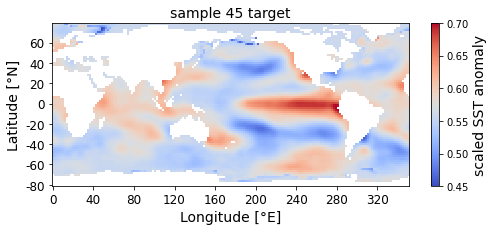

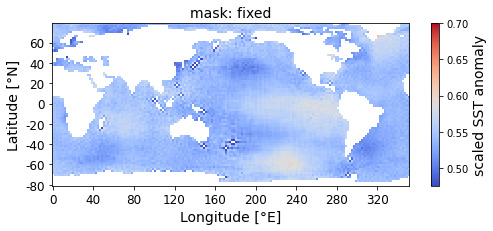

log(mse):  -2.86 

log(mse) only valid grid points:  -2.71 



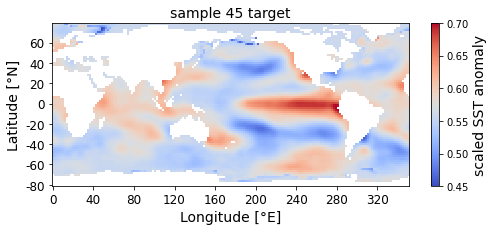

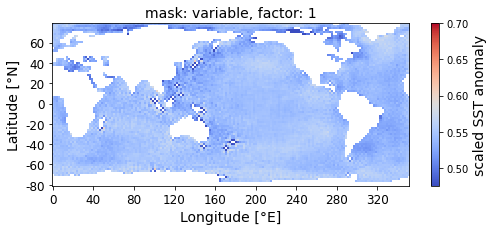

log(mse):  -2.86 

log(mse) only valid grid points:  -2.71 



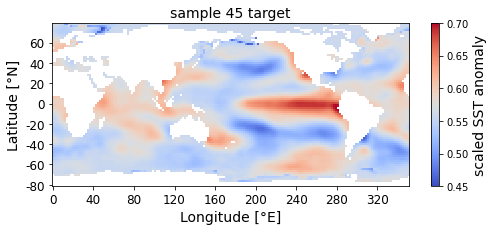

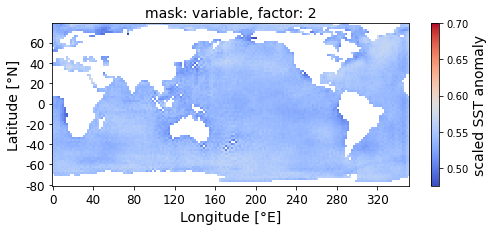

log(mse):  -2.89 

log(mse) only valid grid points:  -2.74 



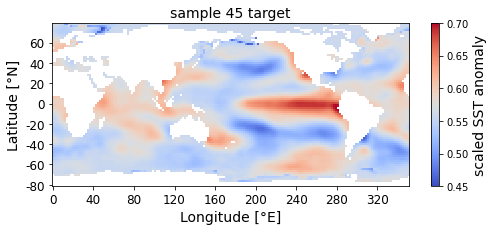

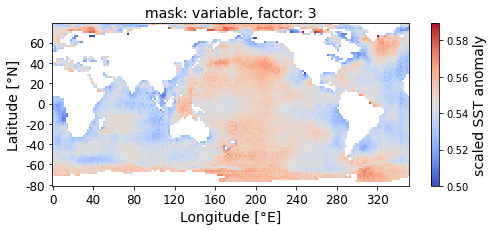

log(mse):  -3.22 

log(mse) only valid grid points:  -3.07 



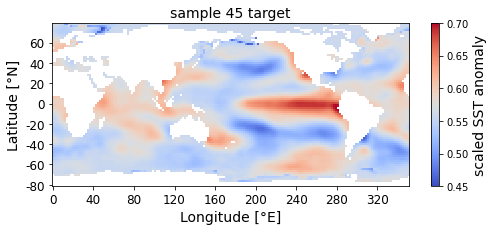

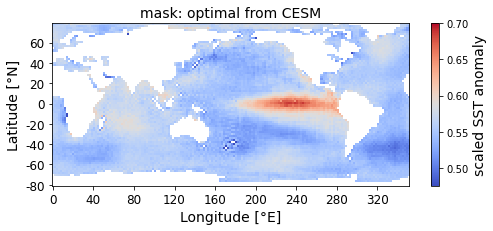

log(mse):  -3.19 

log(mse) only valid grid points:  -3.04 



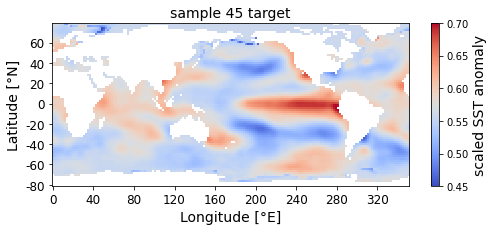

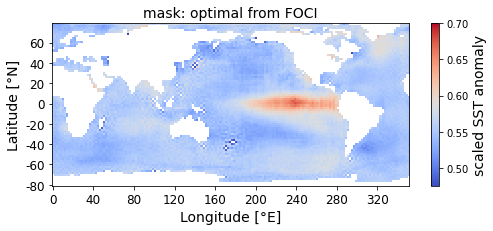

In [83]:
# Plot for specific rate of missing values all reconstructions from final models plus target.
# Plot - if available - DINEOF reconstruction (99% and 95% missing, only).

# Print current rate of missing values:
print(missing_values_all[0][r],' missing\n')

# Loop over models:
for m in range(len(model_shortnames)):
    
    # Print loss:
    print('log(mse): ',np.round(np.log10(np.mean((sample_pred_all[0,m]-val_target[sample_number])**2)),2),'\n')
    print('log(mse) only valid grid points: ',np.round(np.log10(np.mean((sample_pred_all[0,m][valid_gridpoints]-val_target[sample_number][valid_gridpoints])**2)),2),'\n')

    ## Plot target:
    fig, ax = plt.subplots(figsize=(8, 3))
    im = plt.imshow(val_target_nan[sample_number], cmap="coolwarm", interpolation='nearest', vmin=0.45, vmax=0.70)
    cbar = plt.colorbar(im)
    cbar.set_label("scaled SST anomaly", fontsize=14)
    plt.title('sample '+str(sample_number)+' target', fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    # Set x- and y-ticks according to source:
    if source=='realworld':
        plt.xticks(np.arange(0, 176, step=20), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
        plt.yticks(np.arange(9, 80, step=10), [60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    elif source=='CESM':
        plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
        plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    else:
        plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
        plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    plt.show()

    # Plot model reconstructions for current final model:
    fig, ax = plt.subplots(figsize=(8, 3))
    # Specify scaling:
    if m == 3:
        im = plt.imshow(sample_pred_all_nan[0,m], cmap="coolwarm", interpolation='nearest', vmin=0.50)#, vmax=0.65)
    else:
        im = plt.imshow(sample_pred_all_nan[0,m], cmap="coolwarm", interpolation='nearest', vmin=0.475, vmax=0.70)
    cbar = plt.colorbar(im)
    cbar.set_label("scaled SST anomaly", fontsize=14)
    plt.title(model_shortnames[m], fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    # Set x- and y-ticks according to source:
    if source=='realworld':
        plt.xticks(np.arange(0, 176, step=20), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
        plt.yticks(np.arange(9, 80, step=10), [60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    elif source=='CESM':
        plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
        plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    else:
        plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
        plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    plt.show()

0.99  missing

log(mse):  -3.28 

log(mse) only valid grid points:  -3.14 



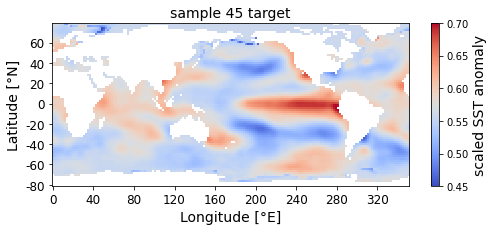

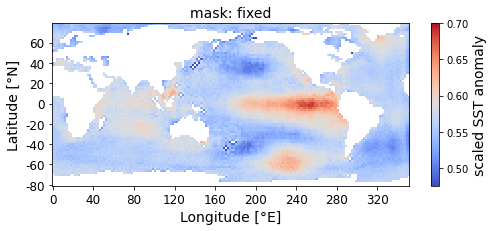

log(mse):  -2.99 

log(mse) only valid grid points:  -2.85 



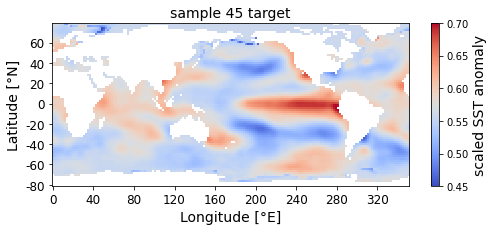

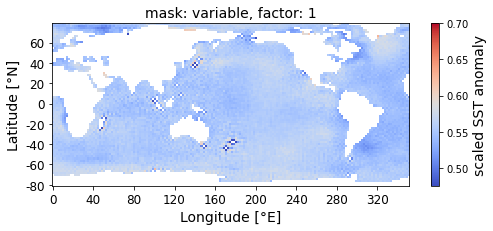

log(mse):  -3.05 

log(mse) only valid grid points:  -2.9 



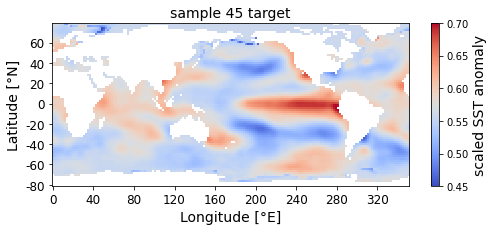

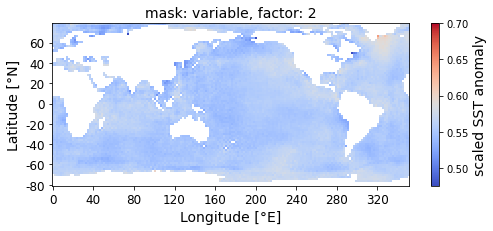

log(mse):  -3.08 

log(mse) only valid grid points:  -2.93 



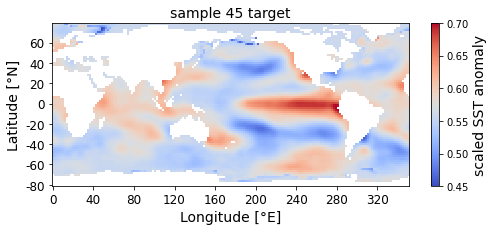

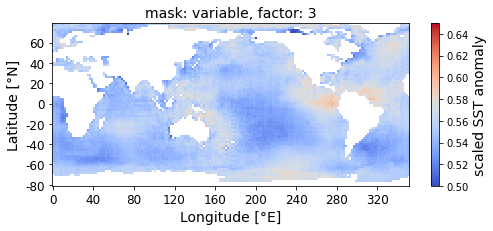

log(mse):  -3.41 

log(mse) only valid grid points:  -3.26 



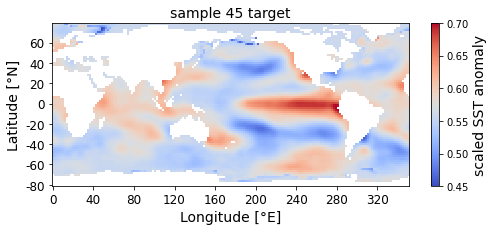

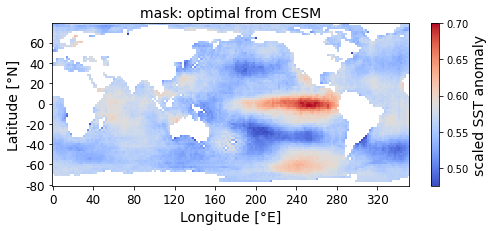

log(mse):  -3.45 

log(mse) only valid grid points:  -3.3 



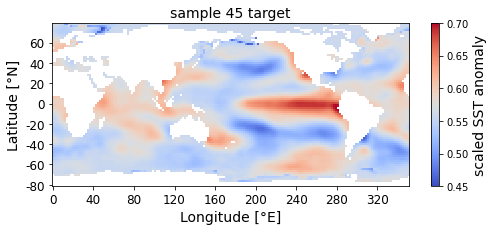

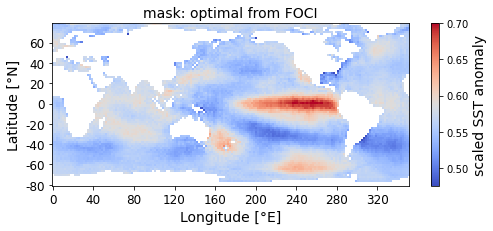

In [73]:
# Plot for specific rate of missing values all reconstructions from final models plus target.
# Plot - if available - DINEOF reconstruction (99% and 95% missing, only).

# Print current rate of missing values:
print(missing_values_all[0][r],' missing\n')

# Loop over models:
for m in range(len(model_shortnames)):
    
    # Print loss:
    print('log(mse): ',np.round(np.log10(np.mean((sample_pred_all[0,m]-val_target[sample_number])**2)),2),'\n')
    print('log(mse) only valid grid points: ',np.round(np.log10(np.mean((sample_pred_all[0,m][valid_gridpoints]-val_target[sample_number][valid_gridpoints])**2)),2),'\n')

    ## Plot target:
    fig, ax = plt.subplots(figsize=(8, 3))
    im = plt.imshow(val_target_nan[sample_number], cmap="coolwarm", interpolation='nearest', vmin=0.45, vmax=0.70)
    cbar = plt.colorbar(im)
    cbar.set_label("scaled SST anomaly", fontsize=14)
    plt.title('sample '+str(sample_number)+' target', fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    # Set x- and y-ticks according to source:
    if source=='realworld':
        plt.xticks(np.arange(0, 176, step=20), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
        plt.yticks(np.arange(9, 80, step=10), [60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    elif source=='CESM':
        plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
        plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    else:
        plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
        plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    plt.show()

    # Plot model reconstructions for current final model:
    fig, ax = plt.subplots(figsize=(8, 3))
    # Specify scaling:
    if m == 3:
        im = plt.imshow(sample_pred_all_nan[0,m], cmap="coolwarm", interpolation='nearest', vmin=0.50, vmax=0.65)
    else:
        im = plt.imshow(sample_pred_all_nan[0,m], cmap="coolwarm", interpolation='nearest', vmin=0.475, vmax=0.70)
    cbar = plt.colorbar(im)
    cbar.set_label("scaled SST anomaly", fontsize=14)
    plt.title(model_shortnames[m], fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    # Set x- and y-ticks according to source:
    if source=='realworld':
        plt.xticks(np.arange(0, 176, step=20), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
        plt.yticks(np.arange(9, 80, step=10), [60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    elif source=='CESM':
        plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
        plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    else:
        plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
        plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    plt.show()

0.95  missing

log(mse):  -3.6 

log(mse) only valid grid points:  -3.46 



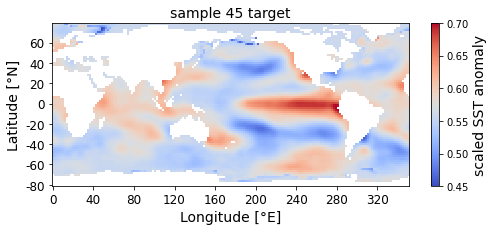

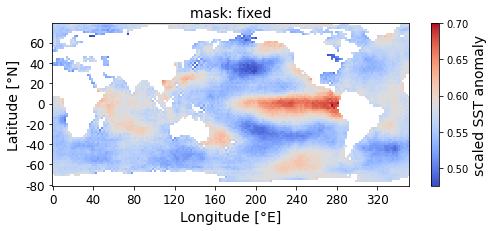

log(mse):  -3.05 

log(mse) only valid grid points:  -2.9 



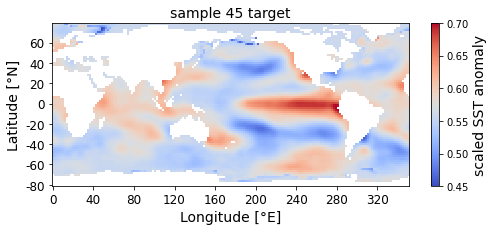

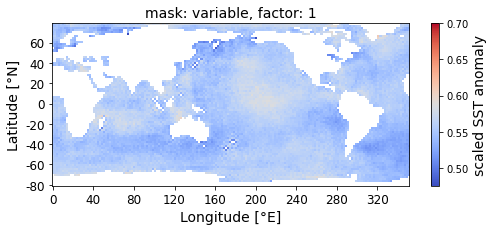

log(mse):  -3.43 

log(mse) only valid grid points:  -3.28 



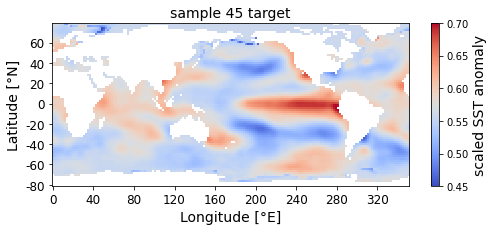

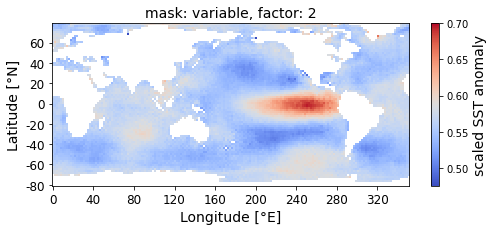

log(mse):  -3.6 

log(mse) only valid grid points:  -3.45 



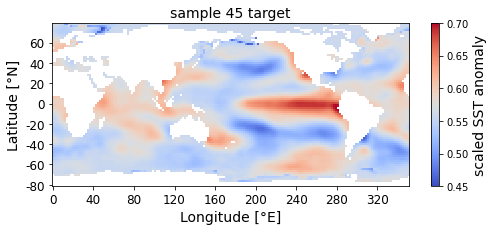

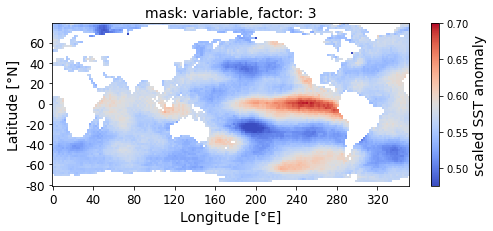

log(mse):  -3.68 

log(mse) only valid grid points:  -3.54 



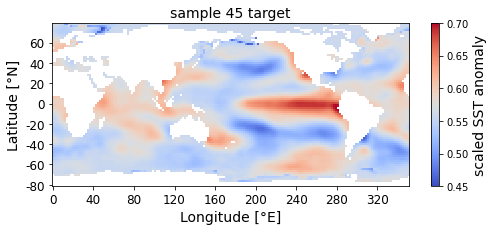

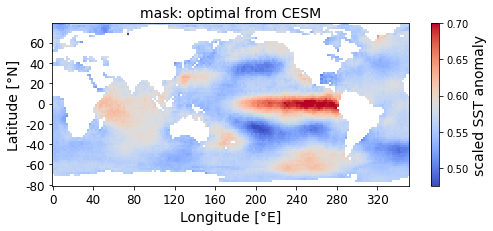

log(mse):  -3.77 

log(mse) only valid grid points:  -3.62 



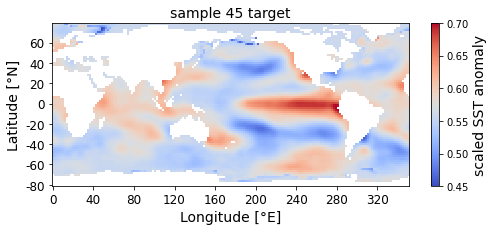

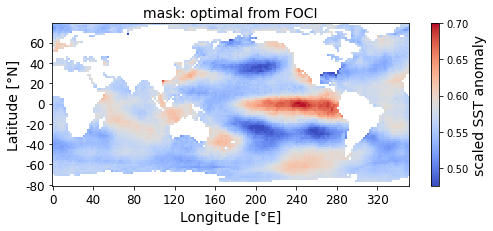

In [52]:
# Plot for specific rate of missing values all reconstructions from final models plus target.
# Plot - if available - DINEOF reconstruction (99% and 95% missing, only).

# Print current rate of missing values:
print(missing_values_all[0][r],' missing\n')

# Loop over models:
for m in range(len(model_shortnames)):
    
    # Print loss:
    print('log(mse): ',np.round(np.log10(np.mean((sample_pred_all[0,m]-val_target[sample_number])**2)),2),'\n')
    print('log(mse) only valid grid points: ',np.round(np.log10(np.mean((sample_pred_all[0,m][valid_gridpoints]-val_target[sample_number][valid_gridpoints])**2)),2),'\n')

    ## Plot target:
    fig, ax = plt.subplots(figsize=(8, 3))
    im = plt.imshow(val_target_nan[sample_number], cmap="coolwarm", interpolation='nearest', vmin=0.45, vmax=0.70)
    cbar = plt.colorbar(im)
    cbar.set_label("scaled SST anomaly", fontsize=14)
    plt.title('sample '+str(sample_number)+' target', fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    # Set x- and y-ticks according to source:
    if source=='realworld':
        plt.xticks(np.arange(0, 176, step=20), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
        plt.yticks(np.arange(9, 80, step=10), [60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    elif source=='CESM':
        plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
        plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    else:
        plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
        plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    plt.show()

    # Plot model reconstructions for current final model:
    fig, ax = plt.subplots(figsize=(8, 3))
    im = plt.imshow(sample_pred_all_nan[0,m], cmap="coolwarm", interpolation='nearest', vmin=0.475, vmax=0.70)
    cbar = plt.colorbar(im)
    cbar.set_label("scaled SST anomaly", fontsize=14)
    plt.title(model_shortnames[m], fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    # Set x- and y-ticks according to source:
    if source=='realworld':
        plt.xticks(np.arange(0, 176, step=20), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
        plt.yticks(np.arange(9, 80, step=10), [60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    elif source=='CESM':
        plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
        plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    else:
        plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
        plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    plt.show()

In [67]:
## Store reconstructions for all models and current sample with current rate of missing values:

# Set path to store results:
path_to_store_results = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/sst_realworld_reconstruction')

# Set filename, rel. amount of missing values = 0.999 requires special treatment:
if missing==0.999:
    file_name_sample_pred_all = "sample_pred_all_sample_"+str(sample_number)+"_missing_" f"{int(missing*1000)}"+".npy"
else:
    file_name_sample_pred_all = "sample_pred_all_sample_"+str(sample_number)+"_missing_" f"{int(missing*100)}"+".npy"
    
# Save reconstructions:
# np.save(path_to_store_results / file_name_sample_pred_all, sample_pred_all)

# Reload reconstructions:
# sample_pred_all = np.load(path_to_store_results / file_name_sample_pred_all)

In [ ]:
# We are not yet pleased with the reconstruction of the model trained on variable discrete mask with augmentation factor 3
# on sample 45. But since we work with data augmentation, each sample is used 3 times.
# Check the other two sparse input versions of sample 45, if we find a more reasonable reconstruction for 99.9% and 99% missing.

In [42]:
## Pick validation sample:
sample_number = 45

## Pick rate of missing values:
r = 1

# Get current rate of missing values:
missing = missing_values_all[0][r]
print('missing: ',missing)

missing:  0.99


In [10]:
model_shortnames

['mask: fixed',
 'mask: variable, factor: 1',
 'mask: variable, factor: 2',
 'mask: variable, factor: 3',
 'mask: optimal from CESM',
 'mask: optimal from FOCI']

In [43]:
# Focus on model with variable mask and factor 3:
m=3

# Get current augmentation factor:
augmentation_factor = augmentation_factor_all[m]

## Load data:

# Open data set:
sst_dataset=xr.open_dataset(path_to_data)

# Start with raw slp fields as lat/lon grids in time, from 1948 to 2022:
sst_fields = (
    sst_dataset.sst
    .sel(time=slice('1880-01-01', '2022-12-01'))
)

# Extract time, latitude and longitude dimensions.
# Already consider, that latitude and longitude are truncated below:
time = sst_fields['time']
latitude = sst_fields['lat'][5:-4]
longitude = sst_fields['lon'][:-4]

# Get number of train and validation samples: Consider augmentation factor!
n_train = int(len(sst_fields) * augmentation_factor * train_val_split)
n_val = ((len(sst_fields) * augmentation_factor) - n_train)

# Compute monthly climatology (here 1980 - 2009) for whole world:
sst_climatology_fields = (
    sst_dataset.sst
    .sel(time=slice('1980-01-01','2009-12-01'))
    .groupby("time.month")
    .mean("time")
)

# Get slp anomaly fields by subtracting monthly climatology from raw slp fields:
sst_anomaly_fields = sst_fields.groupby("time.month") - sst_climatology_fields

# Remove last row (latidute) and last 4 columns (longitude), to have even number of steps in latitude (=88)
# and longitude (=176), that can be evenly divided 4 times by two. This serves as 'quick-and-dirty'
# solution to avoid problems with UPSAMPLING in U-Net. There must be a more elegant way, take care of it later!
sst_anomaly_fields = sst_anomaly_fields.values[:,5:-4,:-4]

# Extend data, if desired:
data = clone_data(data=sst_anomaly_fields, augmentation_factor=augmentation_factor)

## Reconstruct sparse data (as inputs) and complete data (as targets).

# Reload mask for missing values.
# Rel. amount of missing values = 0.999 requires special treatment:
if missing==0.999:
    missing_mask = np.load(Path(paths_to_final_models[m]) / 'missing_' f'{int(missing*1000)}' / 'missing_mask.npy')
else:
    missing_mask = np.load(Path(paths_to_final_models[m]) / 'missing_' f'{int(missing*100)}' / 'missing_mask.npy')

# Use sparse data as inputs and complete data as targets. Split sparse and complete data into training and validation sets. 
# Scale or normlalize data according to statistics obtained from only training data.
train_input, val_input, train_target, val_target, train_min, train_max, train_mean, train_std = split_and_scale_data(
    data, 
    missing_mask, 
    train_val_split, 
    scale_to
)

In [44]:
# Get corresponding samples:
samples = val_input[np.arange((sample_number*augmentation_factor)-2,(sample_number*augmentation_factor)+1)]

# Get targets:
targets = val_target[np.arange((sample_number*augmentation_factor)-2,(sample_number*augmentation_factor)+1)]

# Set zero values in targets to NaN, to highlight land masses and correct contrast in SST anomalies:
targets_nan = np.copy(targets)
targets_nan[targets_nan==0] = float('nan')

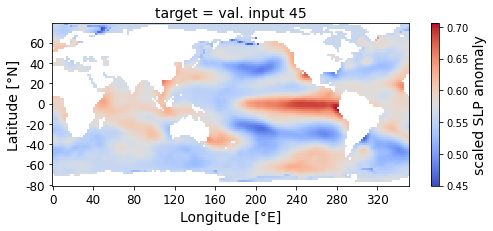

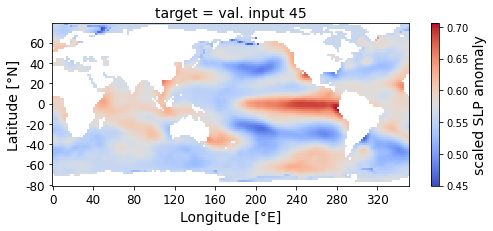

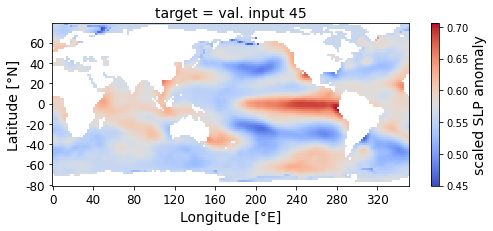

In [45]:
## Plot samples (target):

for i in range(len(targets)):
    
    # Plot:
    fig, ax = plt.subplots(figsize=(8, 3))
    im = plt.imshow(targets_nan[i], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label("scaled SLP anomaly", fontsize=14)
    plt.title('target = val. input '+str(sample), fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    # Set x- and y-ticks according to source:
    plt.xticks(np.arange(0, 176, step=20), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
    plt.yticks(np.arange(9, 80, step=10), [60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    plt.show()

In [46]:
## Reload final pre-trained model for current rate of missing values.

# Set path:
# Rel. amount of missing values = 0.999 requires special treatment:
if missing==0.999:
    model_path = paths_to_final_models[m] + "/missing_" f"{int(missing*1000)}" + "/model"
else:
    model_path = paths_to_final_models[m] + "/missing_" f"{int(missing*100)}" + "/model"

# Reload model
model = tf.keras.models.load_model(Path(model_path))

# Get model prediction for desired samples:
samples_pred = model.predict(samples)[:,:,:,0]

In [47]:
# Set zero values in predictions to NaN, to highlight land masses and correct contrast in SST anomalies:
samples_pred_nan = np.copy(samples_pred)
samples_pred_nan[targets==0] = float('nan')

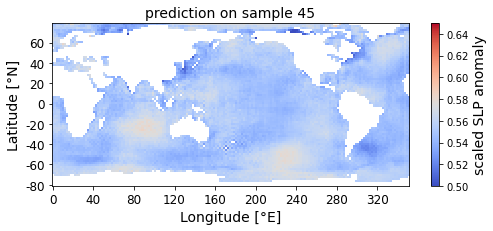

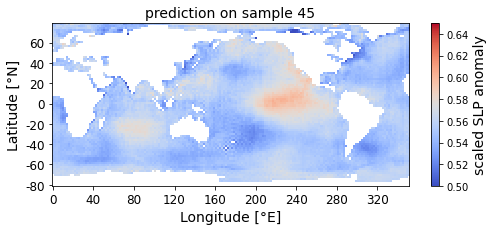

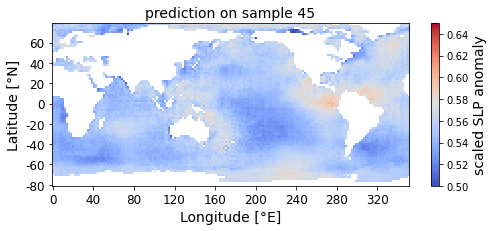

In [51]:
## Plot predictions:

for i in range(len(samples_pred)):
    
    # Plot:
    fig, ax = plt.subplots(figsize=(8, 3))
    im = plt.imshow(samples_pred_nan[i], cmap="coolwarm", interpolation='nearest', vmin=0.5, vmax=0.65)
    cbar = plt.colorbar(im)
    cbar.set_label("scaled SLP anomaly", fontsize=14)
    plt.title('prediction on sample '+str(sample), fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    # Set x- and y-ticks according to source:
    plt.xticks(np.arange(0, 176, step=20), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
    plt.yticks(np.arange(9, 80, step=10), [60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    plt.show()

In [49]:
np.log10(np.mean((samples_pred - targets)**2,axis=(1,2)))

array([-3.02911283, -3.1252339 , -3.0772083 ])